# CS188 Project 2 - Binary Classification Comparative Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

<b><u>DEFINITIONS</b></u>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## Loading Essentials and Helper Functions 

In [1]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot
import itertools

%matplotlib inline
import random 
  
random.seed(42) 

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
# Confusion matrix is a table with two rows and two columns that reports 
# the number of false positives, false negatives, true positives, and true negatives. 
# This allows more detailed analysis than mere proportion of correct classifications (accuracy). 
# Accuracy is not a reliable metric for the real performance of a classifier, 
# because it will yield misleading results if the data set is unbalanced 
# (that is, when the numbers of observations in different classes vary greatly). 
# For example, if there were 95 cats and only 5 dogs in the data, a particular classifier 
# might classify all the observations as cats. The overall accuracy would be 95%, 
# but in more detail the classifier would have a 100% recognition rate (sensitivity) for 
# the cat class but a 0% recognition rate for the dog class.

# C = confusion_matrix(y_true, y_pred)
# C[0, 0]: true negative
# C[1, 0]: false negative
# C[1, 1]: true positive
# C[0, 1]: false positive
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    # Clear the current axes.
    plt.cla()
    # Clear the current figure.
    plt.clf()
    
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i + 0.25 * (1 if i == 0 else -1), format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## [20 Points] Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [4]:
def load_heart_disease_data():
    csv_path = "heartdisease.csv"
    return pd.read_csv(csv_path)

In [5]:
heart_disease = load_heart_disease_data()

### Question 1.1 Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method to display some of the rows so we can visualize the types of data fields we'll be working with, then use the describe method, along with any additional methods you'd like to call to better help you understand what you're working with and what issues you might face. 

In [6]:
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


In [7]:
heart_disease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [8]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
sick        303 non-null bool
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


In [9]:
heart_disease.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
sick        0
dtype: int64

This tells us there is no missing data!

### Question 1.2 Discuss your data preprocessing strategy. Are their any datafield types that are problemmatic and why? Will there be any null values you will have to impute and how do you intend to do so? Finally, for your numeric and categorical features, what if any, additional preprocessing steps will you take on those data elements?

#### Reference
##### For Limited Selection Categorical:
* If you are dealing with a limited selection category, ask yourself if there is a relative relationship between the categories, such that the relative values of the category label are meaningful, and the relationship should be preserved.
* As an example, hotels can be assigned 1-5 star ratings. If I tell you I have a 3 hotel vs. a 5 hotel, the relative distinction is meaningful and implies an important relationship between the two (the 3 star will in all likelihood be cheaper, less nice, worse neighborhood, less amenities than the 5 star etc.). Quantity brackets work the same way (small, medium, large -> 1,2,3). If I onehotencoded that feature, I effectively treat each feature value as independent of one another, and I would lose the relative relationship between those values that the feature previously expressed; in other words, I would be providing the classifier with less useful information. 
* In contrast, if I have a category in which the numeric values are arbitrary (e.g., genres for a film, or countries a person is from), the relative values of the label are probably meaningless (If I code Canada as 3 or 5, is it meaningful?). In that case you do want to onehotencode, because feeding in the feature as is, the classifier will naturally associate a relative value to the feature, when in fact the value is arbitrary. 
* Therefore, as a general rule, if the values you assign can be changed around and still make sense, then onehotencoding is the way to go. If swapping the value assignment wouldn't make sense, then keep it as is. 

##### For Binary Categorical
* If you have a category with only two values, the decision on whether or not to onehotencode boils down to what the two labels mean. Onehotencoding basically creates a feature with a present/absent designation for a particular value. If your binary feature is already effectively a present/absent designation, then onehotencoding is meaningless. (e.g., in our dataset Sick/Not-sick is already a present/absent feature). In contrast, if the binary is two meaningful values (e.g., Male/Female), then a 0 isn't simply 'not female', but is in fact a meaningful designation in its own right (male!). In this case you would onehotencode because you want your classifier to treat both values as actual features and not simply the absence of the other. 

##### Scaling Numeric Features 
* Again there is no absolute right and wrong answer on when to scale numeric features. Obviously if you had one numeric feature with values in the millions, scaling would be essential (assuming the model needed scaling, as many models automatically handle features independently), but if you have a numeric with values in the single digits, then it is unlikely to distort your data too heavily. Having said that, it almost never hurts to scale your numeric features, so when in doubt, scale!

<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>

#### Problems
1. sex is problematic because it's binary categorical feature and not just a simple present/absent designation.
2. cp is problematic because it's limited selection categorical feature and the values can be changed around.
3. restecg is problematic because it's limited selection categorical feature and the values can be changed around.
5. thal is problematic because it's limited selection categorical feature and the values can be changed around.
6. sick is problematic because it's binary categorical target and in string representation.

There are no null values as we've seen earlier.

For numeric features, we want to apply standard scaler. 

For categorical features that are problematic, we want to apply one hot encoding.

For target label, we want to convert it into a binary numeric target (0 or 1) as shown below.

### Question 1.3  Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean sick variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original sick datafield from the dataframe.

In [10]:
heart_disease["sick"] = heart_disease["sick"].astype(int)
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


### Question 1.4 Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to ascertain how each variable performs (is it a binary, or limited selection, or does it follow a gradient? (Note: No need to describe each variable, but pick out a few you wish to highlight)

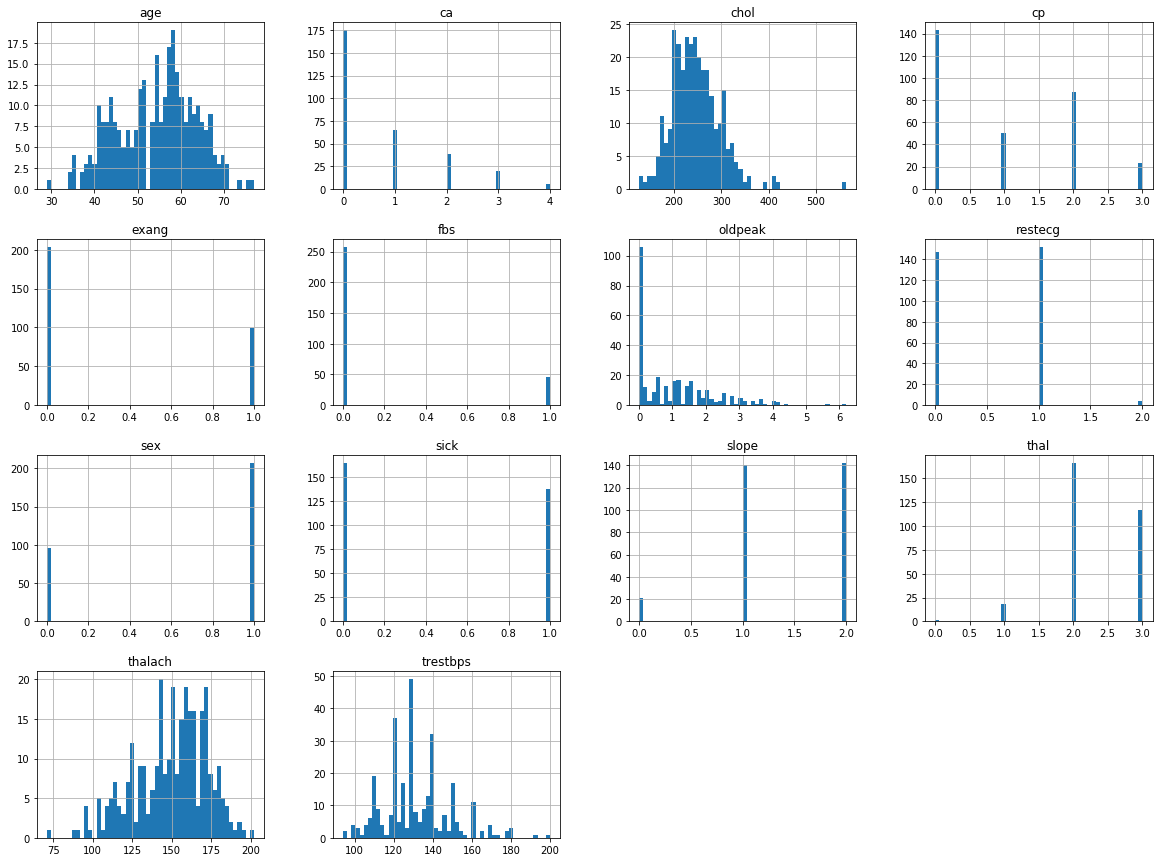

In [11]:
heart_disease.hist(bins=50, figsize=(20,15))
plt.show()

* age: gradient
* ca: limited selection
* chol: gradient
* cp: limited selection
* exang: binary
* fbs: binary
* oldpeak: gradient
* restecg: limited selection
* sex: binary
* sick: binary
* slope: limited selection
* thal: limited selection
* thalach: gradient
* trestbps: gradient

### Question 1.5 We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

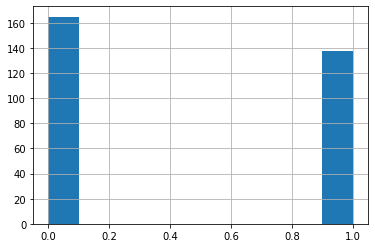

In [12]:
heart_disease["sick"].hist()
plt.show()

In [13]:
heart_disease["sick"].value_counts()

0    165
1    138
Name: sick, dtype: int64

There are 165 healthy people and 138 sick people, so it's pretty balanced.

### Question  1.6 Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

There are two approaches to deal with unbalanced data.
1. Down select the data to a more balanced representation
2. Augument the lacking data with new synthetic data

Both approaches have some issues to deal with. Suppose we have unbalanced dataset with 10 positive samples and 90 negative samples. 
1. If we just down select the data, we can create a new dataset with 10 positive samples and 10 negative samples by arbitrary selecting 10 samples out of 90 negative samples. This can be problematic because now we have much less data to create a good model (20 samples now but we had 100 samples before).
2. If we create additional 80 synthetic positive samples from the 10 real positive samples, we will have 90 positive samples and 90 negative samples, which is balanced. However, the question is: "Does these 80 synthetic positive samples we created actually represent the random samples from positive group?" The answer is no. These 80 synthetic positive samples have some biases from the 10 positive samples we had. The figure below depicts this problem. 

![synthetic data issue](synthetic_data.png)

### Question 1.9 Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations. Intuitively, why do you think some variables correlate more highly than others (hint: one possible approach you can use the sns heatmap function to map the corr() method)?

In [14]:
corr_matrix = heart_disease.corr()
corr_matrix

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,-0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,-0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,-0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,0.430696


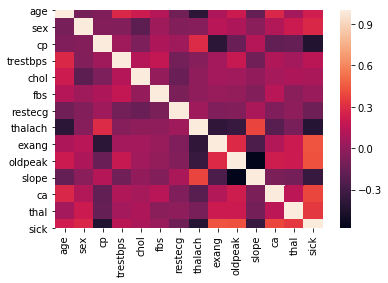

In [15]:
sns.heatmap(corr_matrix)
plt.show()

For this section, I will interpret value above 0.4 as strong correlation and between 0.2 and 0.4 as moderate correlation, and below 0.2 as weak correlation or no correlation.

Recall the definition of the field names
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>

#### Strong correlation
* age and thalach are negatively correlated: -0.398522
* cp and exang are negatively correlated: -0.394280
* cp and sick are negatively correlated: -0.433798
* thalach and exang are negatively correlated: -0.378812
* thalach and slope are positively correlated: 0.386784
* thalach and sick are negatively correlated: -0.421741
* exang and sick are positively correlated: 0.436757
* oldpeak and slope are negatively correlated: -0.577537
* oldpeak and sick are positively correlated: 0.430696
* ca and sick are positively correlated: 0.391724

#### Moderate correlation
* age and trestbps are posively correlated: 0.279351
* age and chol are positively correlated: 0.213678
* age and oldpeak are positively correlated: 0.210013
* age and thal are positively correlated: 0.276326
* age and sick are positively correlated: 0.225439
* sex and thal are positively correlated: 0.210041
* sex and sick are positively correlated: 0.280937
* cp and thalach are positively correlated: 0.295762
* thalach and oldpeak are negatively correlated: -0.344187
* thalach and ca are negatively correlated: -0.213177
* exang and oldpeak are positively correlated: 0.288223
* exang and slope are negatively correlated: -0.257748
* exang and thal are positively correlated: 0.206754
* oldpeak and ca are positively correlated: 0.222682
* oldpeak and thal are positively correlated: 0.210244
* thal and sick are positively correlated: 0.344029   

Since there are so many correlations, I will only highlight some of them. Specifically, let's talk about (exang, sick) and (age, sick).

exang is exercise induced angina (i.e. a type of chest pain caused by reduced blood flow to the heart). sick indicates the presence of Heart disease. So it makes sense that exang and sick are highly correlated.

What about age and sick? Well, it makes sense that age and sick aren't as only somewhat correlated compared to previous case because not every old people get heart attack. Yes, if you get older, you are more likely to get heart attack but some old people are healthy. That's the intuition.


## [30 Points] Part 2. Prepare the Data 

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data: 1. Will simply be the raw numeric data that hasn't gone through any additional pre-processing. The other, will be data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Question 2.1 Save the target column as a separate array and then drop it from the dataframe. 

In [16]:
heart_disease_X = heart_disease.drop("sick", axis=1)
heart_disease_y = heart_disease["sick"]

### Question 2.2 First Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 70% of your total dataframe (hint: use the train_test_split method) Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [17]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(heart_disease_X, heart_disease_y, test_size=0.3)
print("heart_disease_X: ", heart_disease_X.shape)
print("X_train_raw: ", X_train_raw.shape)
print("X_test_raw: ", X_test_raw.shape)
print("heart_disease_y: ", heart_disease_y.shape)
print("y_train_raw: ", y_train_raw.shape)
print("y_test_raw: ", y_test_raw.shape)

heart_disease_X:  (303, 13)
X_train_raw:  (212, 13)
X_test_raw:  (91, 13)
heart_disease_y:  (303,)
y_train_raw:  (212,)
y_test_raw:  (91,)


### Question 2.3 Now create a pipeline to conduct any additional preparation of the data you would like. Output the resulting array to ensure it was processed correctly.

In [18]:
heart_disease_X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [19]:
categorical_features = ["sex", "cp", "restecg", "thal"]
numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]

pipeline = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(), categorical_features)
])

In [20]:
processed_heart_disease = pipeline.fit_transform(heart_disease_X)

/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
processed_heart_disease.shape

(303, 18)

In [22]:
processed_heart_disease

array([[ 0.9521966 ,  0.76395577, -0.25633371, ...,  1.        ,
         0.        ,  0.        ],
       [-1.91531289, -0.09273778,  0.07219949, ...,  0.        ,
         1.        ,  0.        ],
       [-1.47415758, -0.09273778, -0.81677269, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.50364073,  0.70684287, -1.029353  , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.29046364, -0.09273778, -2.2275329 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.29046364, -0.09273778, -0.19835726, ...,  0.        ,
         1.        ,  0.        ]])

### Question 2.4 Now create a separate, processed training data set by dividing your processed dataframe into training and testing cohorts, using the same settings as Q2.2 (REMEMBER TO USE DIFFERENT TRAINING AND TESTING VARIABLES SO AS NOT TO OVERWRITE YOUR PREVIOUS DATA). Output the resulting shapes of your training and testing samples to confirm that your split was successful, and describe what differences there are between your two training datasets.

In [23]:
X_train_processed, X_test_processed, y_train_processed, y_test_processed = train_test_split(processed_heart_disease, heart_disease_y, test_size=0.3, random_state=42)
print("heart_disease_X: ", heart_disease_X.shape)
print("X_train_processed: ", X_train_processed.shape)
print("X_test_processed: ", X_test_processed.shape)
print("heart_disease_y: ", heart_disease_y.shape)
print("y_train_processed: ", y_train_processed.shape)
print("y_test_processed: ", y_test_processed.shape)

heart_disease_X:  (303, 13)
X_train_processed:  (212, 18)
X_test_processed:  (91, 18)
heart_disease_y:  (303,)
y_train_processed:  (212,)
y_test_processed:  (91,)


* Processed dataset has values of mean 0 and variant 1 for each numerical features. 
* Processed dataset has more columns due to one hot encoding on categorical features.

## [50 Points] Part 3. Learning Methods 

We're finally ready to actually begin classifying our data. To do so we'll employ multiple learning methods and compare result.

### Linear Decision Boundary Methods 

### SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

### Question 3.1.1 Implement a Support Vector Machine classifier on your RAW dataset. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings, but set probability = True.

In [24]:
# SVM
clf = SVC(probability=True)
clf.fit(X_train_raw, y_train_raw)

/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### Question 3.1.2 Report the accuracy, precision, recall, F1 Score, and confusion matrix of the resulting model.

In [25]:
def report_metrics(y_true, y_pred, labels):
    print("accuracy: ", accuracy_score(y_true, y_pred))
    print("precision: ", precision_score(y_true, y_pred))
    print("recall: ", recall_score(y_true, y_pred))
    print("F1: ", f1_score(y_true, y_pred))
    draw_confusion_matrix(y_true, y_pred, labels)

/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy:  0.4945054945054945
precision:  0.0
recall:  0.0
F1:  0.0


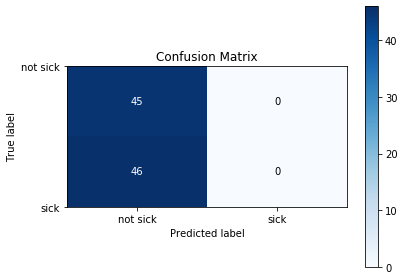

In [26]:
report_metrics(y_test_raw, clf.predict(X_test_raw), ["not sick", "sick"])

### Question 3.1.3 Discuss what each measure is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.

Reference: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

* accuracy = (True Positive + True Negative) / (True Positive + True Negative + False Positive + False Negative) 
* precision = True Positive / (True Positive + False Positive)
* recall = True Pisitive / (True Positive + False Negative)
* f1 = 2 * (precision * recall) / (precision + recall)


* accuracy is the most basic metric to measure the performance of a model
* precision is measuring "Out of total predicted positive, how many of them are actually positive?". This is a good metric to use when the cost of false positive is high. For example, think about email spam detection model. A false positive in this model means an email that is non-spam is classified as spam. This is very costly because we don't want email users to lose important emails.
* recall is measuring "Out of total actual positive, how many of them our classifier has labeled as positive?". This is a good metric to use when the cost of false negative is high. For example, think about cancer detection. A false negative in this model means a patient with cancer is classified as not having a cancer. This is very costly because if a patient has a cancer we want to treat them as soon as possible!
* f1 score is used when we care both precision and recall AND when there is an uneven class distribution (to avoid model simply predicting true all the time and most of the test set has positive labels, which results in high accurarcy while the model is actually performing poorly). For example, think about fraud detection. We don't want to miss fraudrous activity but we also don't want to wrongfully accuse people for fraud.

### Question 3.1.4 Plot a Receiver Operating Characteristic curve, or ROC curve, and describe what it is and what the results indicate

In [27]:
def plot_roc(clf, X, y):
    y_score = clf.decision_function(X)
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

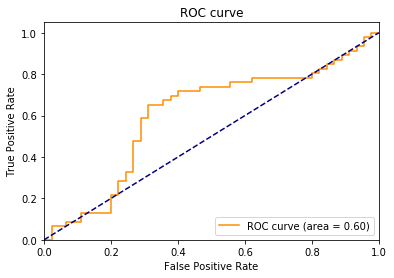

In [28]:
plot_roc(clf, X_test_raw, y_test_raw)

Reference: https://www.youtube.com/watch?v=4jRBRDbJemM

For classification problems, we can set different threshold to get different confusion matrix. We want to answer this question: Which threshold should we use? ROC curve is a curve that shows the summary of diffetent confusion matrix in one place. The x-axis is False Positive Rate and the y-axis is True Positive Rate. The dotted diagonal line shows where True Positive Rate = False Positive Rate. Every point on ROC curve corresponds to a threshold and its True Positive Rate and False Positive Rate. In general, we want to have high True Positive Rate and low False Positive Rate (i.e. region above the dotted diagonal line). 

Since the ROC curve is pretty close to the dasshed line all the time, so the model is performing pretty bad for any classification threshold.

### Question 3.1.5 Rerun, using the exact same settings, only this time use your processed data as inputs. 

In [29]:
clf = SVC(probability=True)
clf.fit(X_train_processed, y_train_processed)

/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

### Question 3.1.6 Report the accuracy, precision, recall, F1 Score, confusion matrix, and plot the ROC Curve of the resulting model.

accuracy:  0.8241758241758241
precision:  0.7777777777777778
recall:  0.8536585365853658
F1:  0.8139534883720929


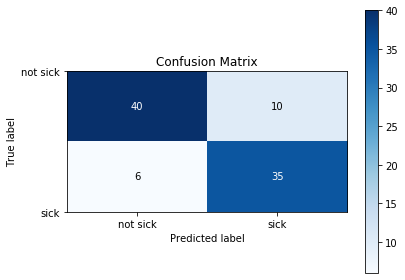

In [30]:
report_metrics(y_test_processed, clf.predict(X_test_processed), ["not sick", "sick"])

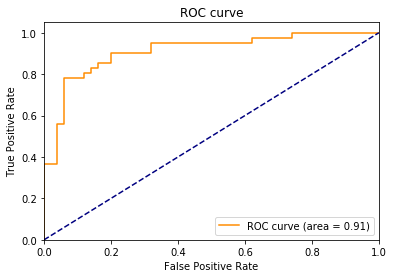

In [31]:
plot_roc(clf, X_test_processed, y_test_processed)

### Question 3.1.7 Hopefully you've noticed a dramatic change in performance. Discuss why you think your new data has had such a dramatic impact. 

There are two things I did to make such a dramatic performance improvement -- standard scaling of numerical features and one hot encoding of problematic categorical features.

#### Standard Scaling
Standard scaling makes sure the model treats each feature equally. This is expecially important for algorithm like KNN where it's using euclidean distance between two data points because if one feature has huge values, the distance will be largely determined by that one feature.

#### One Hot Encoding
One hod encoding makes sure the values of a categorical feature make sense. For example, cp originally has a value between 0 and 3. But the numbering of 1, 2, 3 implies there's a relative relationship between these categories (i.e. 2 is more serious pain than 1 and 3 is more serious pain than 2). But there isn't! Each category (1, 2, and 3) should be treated independently as present/absence of the feature.

These preprocessings were significant because now the features more accurately capture whether or not they are relevant to the person being sick or not.

### Question 3.1.8 Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. Again report your Accuracy, Precision, Recall, F1 scores, and Confusion matrix and plot the new ROC curve.  

In [32]:
clf = SVC(probability=True, kernel='linear')
clf.fit(X_train_processed, y_train_processed)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

accuracy:  0.8351648351648352
precision:  0.7954545454545454
recall:  0.8536585365853658
F1:  0.8235294117647058


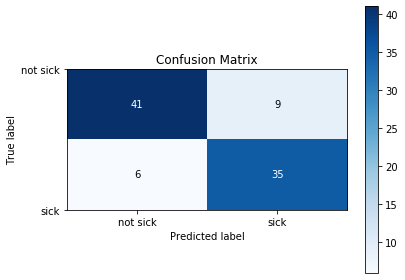

In [33]:
report_metrics(y_test_processed, clf.predict(X_test_processed), ["not sick", "sick"])

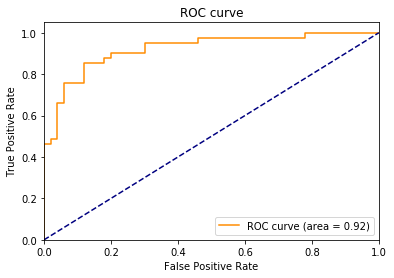

In [34]:
plot_roc(clf, X_test_processed, y_test_processed)

### Question 3.1.9 Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

#### What does kernel do?
The idea of kernel is that we want to find a non-linear decision boundary of our dataset. But many machine learning algorithms including SVM can only find linear decision boudnary. So what we do is to increase the number of features of the dataset (i.e. increase the dimensions of the input space). This is called kernel method. We apply kernel function, which maps input from n to m (n < m), to our input features, and obtain higher dimnesional input space. Then we find a linear decision boundary in this new input space, which results in non-linear decision boundary in the origianl input space.

#### rbf (radial basis function kernel)
Essentially rbf is a kernel function that allows SVM to find non-linear decision boundary by transforming input space into higher order space.

#### linear
Setting kernel='linear' means no need to map to an even higher dimensional feature space.

#### Analysis
It looks like linear kernel performs slightly better in this dataset. This indicates three things:
* Number of features are already enough
* The dataset is more or less linearly separable  (SVM is using soft margin)
* Using RBF slightly overfits the training set compared to linear kernel

### Logistic Regression

Knowing that we're dealing with a linearly configured dataset, let's now try another classifier that's well known for handling linear models: Logistic Regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### Question 3.2.1 Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model. For this initial model set the solver = 'sag' and max_iter= 10). Report on the same four metrics as the SVM and graph the resulting ROC curve.

In [35]:
# Logistic Regression
clf = LogisticRegression(solver='sag', max_iter=10)
clf.fit(X_train_processed, y_train_processed)

/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
clf.coef_, clf.intercept_

(array([[ 0.10591823,  0.09921201,  0.01887168, -0.54686619,  0.71276133,
         -0.58718509,  0.43727743,  1.06621809,  0.06556164, -0.7899641 ,
         -0.49172329,  0.17059038, -0.47285353,  0.1523555 , -0.10099827,
         -0.3039927 , -0.66701342,  0.92209673]]), array([-0.29995452]))

accuracy:  0.8571428571428571
precision:  0.8333333333333334
recall:  0.8536585365853658
F1:  0.8433734939759037


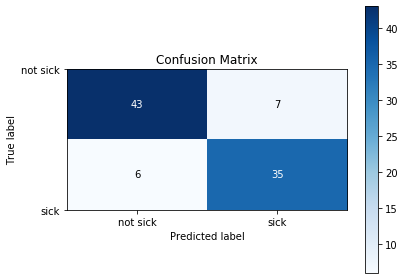

In [37]:
report_metrics(y_test_processed, clf.predict(X_test_processed), ["not sick", "sick"])

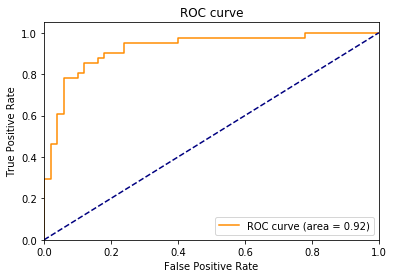

In [38]:
plot_roc(clf, X_test_processed, y_test_processed)

### Question 3.2.2 Did you notice that when you ran the previous model you got the following warning: "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge". Check the documentation and see if you can implement a fix for this problem, and again report your results.

In [39]:
# Logistic Regression
clf = LogisticRegression(solver='sag', max_iter=10000)
clf.fit(X_train_processed, y_train_processed)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
clf.coef_, clf.intercept_

(array([[ 0.10349624,  0.08993016,  0.05612324, -0.55654692,  0.71118784,
         -0.52530364,  0.51924225,  1.12179239,  0.10673519, -0.75798124,
         -0.47660773,  0.20662816, -0.42910509,  0.21641553, -0.16371267,
         -0.25416306, -0.57580525,  0.98761959]]), array([-0.53013059]))

accuracy:  0.8571428571428571
precision:  0.8333333333333334
recall:  0.8536585365853658
F1:  0.8433734939759037


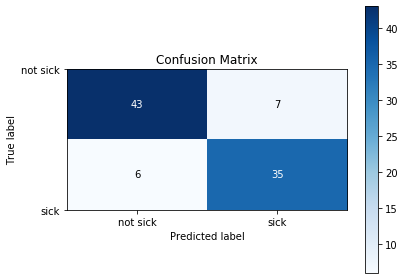

In [41]:
report_metrics(y_test_processed, clf.predict(X_test_processed), ["not sick", "sick"])

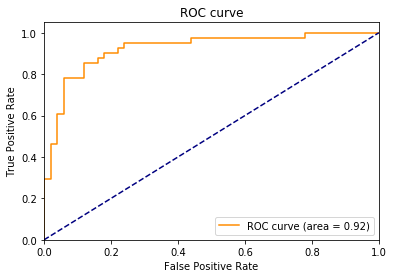

In [42]:
plot_roc(clf, X_test_processed, y_test_processed)

### Question 3.2.3 Explain what you changed, and why that produced an improved outcome. 

What we've changed above is max_iter, which represents number of max iterations we want to iterate during the training. When it converges, it means it can no longer decrease the training error and thus found an optimal parameters for the model. It didn't produce an improved outcome by accident. In fact, when you print the parameters of the classifier (which you can access by clf.coef_ and clf.intercept_), they are actually different (i.e. they are indeed different classifier)! Generally speaking, it should improve the test performance. If we test the performance with different test set, it would probably have better result.

### Question 3.2.4 Rerun your logistic classifier, but modify the penalty = 'none', solver='sag' and again report the results.

In [43]:
# Logistic Regression
clf = LogisticRegression(solver='sag', penalty='none', max_iter=10000)
clf.fit(X_train_processed, y_train_processed)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy:  0.8461538461538461
precision:  0.8292682926829268
recall:  0.8292682926829268
F1:  0.8292682926829268


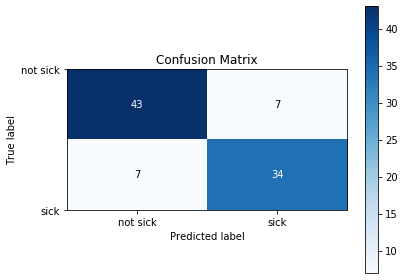

In [44]:
report_metrics(y_test_processed, clf.predict(X_test_processed), ["not sick", "sick"])

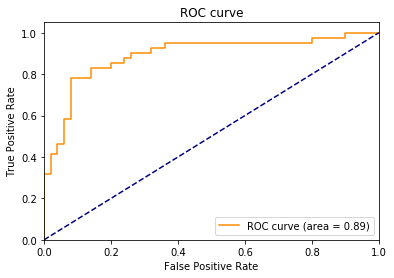

In [45]:
plot_roc(clf, X_test_processed, y_test_processed)

### Question 3.2.5 Explain what what the penalty parameter is doing in this function, what the solver method is, and why this combination likely produced a more optimal outcome. 

The penalty option specifies the type of regularization we want to use. Regularization prevents our learning model from overfitting the training data, and thus generally gives us better performance for test set. The solver options specifies what algorithm to use to minimize the error and tune the parameters of the learning model. The combination above actually are more likely to give worse outcome because it is more likely to overfit the training model. With regularization we had F1 score of 0.84 but with no regularization, we have F1 score of 0.82.

### Question 3.2.6 Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary?

Reference: http://www.cs.toronto.edu/~kswersky/wp-content/uploads/svm_vs_lr.pdf

Logistic regression focuses on maximizing the probability of the data (i.e. If the data point is positive, we want our classfier to output a value/probability close to 1. If the data point is negative, we want our classifier to output a value/probability close to 0).

SVM tries to find the separating hyperplane that correctly separates positive and negative samples, and also maximize the distance of the closest points to the margin (the support vectors). If we use soft margin, then the separation is not strict. The classifer will try to separate the target labels as much as possible (and of course, maximize the margin). 

### Clustering Approaches 

Let us now try a different approach to classification using a clustering algorithm. Specifically, we're going to be using K-Nearest Neighbor, one of the most popular clustering approaches. 

### K-Nearest Neighbor  

### Question 3.3.1 Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. Report on the accuracy of the resulting model.

In [46]:
# k-Nearest Neighbors algorithm
clf = KNeighborsClassifier()
clf.fit(X_train_processed, y_train_processed)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Question 3.3.2 For clustering algorithms, we use different measures to determine the effectiveness of the model. Specifically here, we're interested in the Homogeneity Score, Completeness Score, V-Measure, Adjusted Rand Score, and Adjusted Mutual Information. Calculate each score (hint review the SKlearn Metrics Clustering documentation for how to implement).

In [47]:
def report_knn_metrics(y_true, y_test):
    print("homogeneity_score:", homogeneity_score(y_true, y_test))
    print("completeness_score:", completeness_score(y_true, y_test))
    print("v_measure_score:", v_measure_score(y_true, y_test))
    print("adjusted_rand_score:", adjusted_rand_score(y_true, y_test))
    print("adjusted_mutual_info_score:", adjusted_mutual_info_score(y_true, y_test))

In [48]:
report_knn_metrics(y_test_processed, clf.predict(X_test_processed))

homogeneity_score: 0.28233267279666796
completeness_score: 0.28094946431696816
v_measure_score: 0.2816393702376524
adjusted_rand_score: 0.3582354435543025
adjusted_mutual_info_score: 0.27509204060457404


/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


### Question 3.3.3 Explain what each score means and interpret the results for this particular model. 

**homogeneity_score**: A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

**completeness_score**: A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

**v_measure_score**: The V-measure is the harmonic mean between homogeneity and completeness

**adjusted_rand_score**: The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

**adjusted_mutual_info_score**: Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared.


Here's basically what these scores are tellings us: How cleanly does the division occurs? It tells us how the dataset can be cleanly clustered.

As we're beginning to see, the input parameters for your model can dramatically impact the performance of the model. How do you know which settings to choose? Studying the models and studying your datasets are critical as they can help you anticipate which models and settings are likely to produce optimal results. However sometimes that isn't enough, and a brute force method is necessary to determine which parameters to use. For this next question we'll attempt to optimize a parameter using a brute force approach. 

### Question 3.3.4 Parameter Optimization.  The KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 10, 20, 50, and 100. Run your model for each value and report the 6 measures (5 clustering specific plus accuracy) for each. Report on which n value produces the best accuracy and V-Measure. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

In [49]:
ns = [1, 2, 3, 5, 10, 20, 50, 100]
for n in ns:
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train_processed, y_train_processed)
    print("================= n_neighbors:", n, "======================")
    report_knn_metrics(y_test_processed, clf.predict(X_test_processed))
    print("accuracy_score:", accuracy_score(y_test_processed, clf.predict(X_test_processed)))

================= n_neighbors: 1 ======================
homogeneity_score: 0.05872514152589703
completeness_score: 0.05843743442871423
v_measure_score: 0.05858093472724649
adjusted_rand_score: 0.06519226709507984
adjusted_mutual_info_score: 0.05076741594657647
accuracy_score: 0.6373626373626373
================= n_neighbors: 2 ======================
homogeneity_score: 0.1489274579331926
completeness_score: 0.16168454126061935
v_measure_score: 0.1550440277873086
adjusted_rand_score: 0.19424370349169998
adjusted_mutual_info_score: 0.14193859755796748
accuracy_score: 0.7252747252747253
================= n_neighbors: 3 ======================
homogeneity_score: 0.1667304603829775
completeness_score: 0.16591361200215948
v_measure_score: 0.16632103325679926
adjusted_rand_score: 0.21464428708928338
adjusted_mutual_info_score: 0.15911910014966105
accuracy_score: 0.7362637362637363
================= n_neighbors: 5 ======================
homogeneity_score: 0.28233267279666796
completeness_score: 

/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behav

homogeneity_score: 0.28314007249556694
completeness_score: 0.2975486364146794
v_measure_score: 0.2901655954134666
adjusted_rand_score: 0.35829284523409155
adjusted_mutual_info_score: 0.27726041518302225
accuracy_score: 0.8021978021978022


/Users/one/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


* best accuracy_score: 0.8791208791208791 (n = 20)
* best v_measure_score: 0.46851976850647986 (n = 20)

### Question 3.3.5 When are clustering algorithms most effective, and what do you think  explains the comparative results we achieved?  

Clustering is effective when the dataset is not linearly separable. Consider the dataset of diabete below. Red indicates type I diabete, blue indicates type II diabete, and green indicates healthy people. We want to classify whether a person has diabete or not. Obviously, there isn't a way to separate red and blue from green with a straight line. But, with KNN, since it determines its class based on its distance to neighbors' classes, it will be effective and correctly classify the dataset below.

![knn_effective](knn_effective.png)

The comparative results we achived suggest that our dataset is "clustered" the best when number of neighbors we check is 20.